# Retail Store Demand Forecasting

Objective  
Explore historical retail store data and check how past sales and promotion signals relate to demand one week ahead.

Hypotheses  

- **Null hypothesis (H₀)**: Past sales and promotions do not add significant predictive signal for next week product demand.  
- **Alternative hypothesis (Hₐ)**: Past sales and promotions add significant predictive signal for next week product demand.


## 1. Setup and data loading


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

plt.style.use("default")

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

In [2]:
# Load dataset
csv_path = (
    "data/retail_store_inventory.csv"  # place notebook and CSV in the same folder
)
df = pd.read_csv(csv_path)

df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-02,S001,P0001,Groceries,West,116,81,104,27.95,10,Cloudy,0,30.89,Spring
2,2022-01-03,S001,P0001,Electronics,West,154,5,189,62.70,20,Rainy,0,58.22,Winter
3,2022-01-04,S001,P0001,Groceries,South,85,58,193,77.88,15,Cloudy,1,75.99,Winter
4,2022-01-05,S001,P0001,Groceries,South,238,147,37,28.46,20,Sunny,1,29.40,Winter


## 2. Data overview and basic cleaning


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Price               73100 non-null  float64
 9   Discount            73100 non-null  int64  
 10  Weather Condition   73100 non-null  object 
 11  Holiday/Promotion   73100 non-null  int64  
 12  Competitor Pricing  73100 non-null  float64
 13  Seasonality         73100 non-null  object 
dtypes: float64(2), int64(5), object(7)
memory usage: 7.8+ MB


In [4]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,73100,731,2022-01-01,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Store ID,73100,5,S001,14620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product ID,73100,20,P0001,3655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,73100,5,Furniture,14699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Region,73100,4,East,18349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inventory Level,73100.0,NaN,NaN,NaN,274.469877,129.949514,50.0,162.0,273.0,387.0,500.0
Units Sold,73100.0,NaN,NaN,NaN,136.46487,108.919406,0.0,49.0,107.0,203.0,499.0
Units Ordered,73100.0,NaN,NaN,NaN,110.004473,52.277448,20.0,65.0,110.0,155.0,200.0
Price,73100.0,NaN,NaN,NaN,55.135108,26.021945,10.0,32.65,55.05,77.86,100.0
Discount,73100.0,NaN,NaN,NaN,10.009508,7.083746,0.0,5.0,10.0,15.0,20.0


### 2.1 Column description

Short summary of main columns from this dataset.

- `Date`: Calendar date for the record.  
- `Store ID`: Store identifier.  
- `Product ID`: Product identifier.  
- `Category`: Product category.  
- `Region`: Store region.  
- `Inventory Level`: Stock level for that row.  
- `Units Sold`: Actual units sold on that date.  
- `Units Ordered`: Units placed on order.  
- `Demand Forecast`: Forecast quantity available in the raw data.  
- `Price`: Product price.  
- `Discount`: Discount percentage for that day.  
- `Weather Condition`: Weather label for that day.  
- `Holiday/Promotion`: Flag that marks holiday or promotion.  
- `Competitor Pricing`: Competitor price for the same product.  
- `Seasonality`: Season label.


### 2.2 Convert date column and check missing values


In [5]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")

missing_summary = df.isna().mean().sort_values(ascending=False)
missing_summary

Date                  0.0
Store ID              0.0
Product ID            0.0
Category              0.0
Region                0.0
Inventory Level       0.0
Units Sold            0.0
Units Ordered         0.0
Price                 0.0
Discount              0.0
Weather Condition     0.0
Holiday/Promotion     0.0
Competitor Pricing    0.0
Seasonality           0.0
dtype: float64

In [6]:
# Drop rows with missing Date or Units Sold, since those fields are central for this analysis
df = df.dropna(subset=["Date", "Units Sold"]).copy()

df.sort_values(["Store ID", "Product ID", "Date"], inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-02,S001,P0001,Groceries,West,116,81,104,27.95,10,Cloudy,0,30.89,Spring
2,2022-01-03,S001,P0001,Electronics,West,154,5,189,62.70,20,Rainy,0,58.22,Winter
3,2022-01-04,S001,P0001,Groceries,South,85,58,193,77.88,15,Cloudy,1,75.99,Winter
4,2022-01-05,S001,P0001,Groceries,South,238,147,37,28.46,20,Sunny,1,29.40,Winter


## 3. Missing values ratio


In [7]:
missing_ratio = df.isna().sum().sort_values(ascending=False) / len(df) * 100
missing_ratio_df = missing_ratio.reset_index()
missing_ratio_df.columns = ["Column", "Missing_Ratio_percent"]
missing_ratio_df

,Column,Missing_Ratio_percent
0,Date,0.0
1,Store ID,0.0
2,Product ID,0.0
3,Category,0.0
4,Region,0.0
5,Inventory Level,0.0
6,Units Sold,0.0
7,Units Ordered,0.0
8,Price,0.0
9,Discount,0.0


The table shows the percentage of missing values per column.  
Every column has 0 percent missing values, so no imputation or row dropping is needed based on missingness.


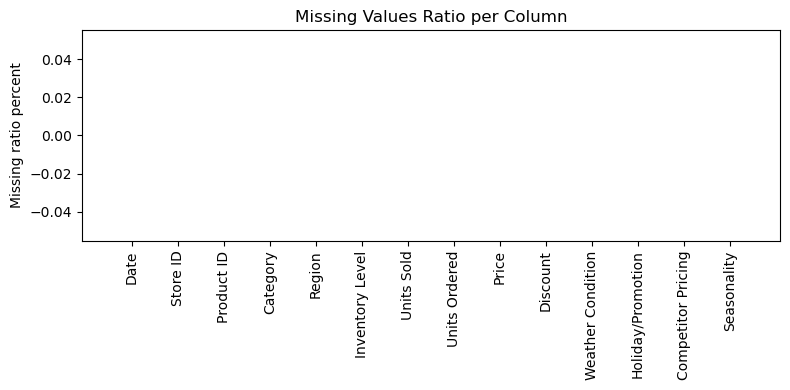

In [8]:
plt.figure(figsize=(8, 4))
plt.bar(missing_ratio_df["Column"], missing_ratio_df["Missing_Ratio_percent"])
plt.xticks(rotation=90)
plt.ylabel("Missing ratio percent")
plt.title("Missing Values Ratio per Column")
plt.tight_layout()
plt.show()

The bar plot confirms visually that all features have complete data.  
This simplifies further preprocessing because we do not need to handle missing values.


## 4. Low variance filter


In [9]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols

['Inventory Level',
 'Units Sold',
 'Units Ordered',
 'Price',
 'Discount',
 'Holiday/Promotion',
 'Competitor Pricing']

The list above shows all numeric variables that will be checked for low variance.


In [10]:
variance = df[numeric_cols].var().sort_values()
variance_df = variance.reset_index()
variance_df.columns = ["Numeric_Column", "Variance"]
variance_df

,Numeric_Column,Variance
0,Holiday/Promotion,0.249996
1,Discount,50.179461
2,Price,677.141602
3,Competitor Pricing,685.989846
4,Units Ordered,2732.931607
5,Units Sold,11863.437048
6,Inventory Level,16886.876218


The table reports variance for each numeric feature.

- `Holiday/Promotion` has variance around 0.25.  
- For a binary 0/1 variable this is actually the maximum possible variance and indicates a balanced flag.  
- Other variables have larger variance because they measure quantities or prices on continuous scales.

With a typical low variance filter threshold (for example zero or a very small value), no numeric feature would be removed.


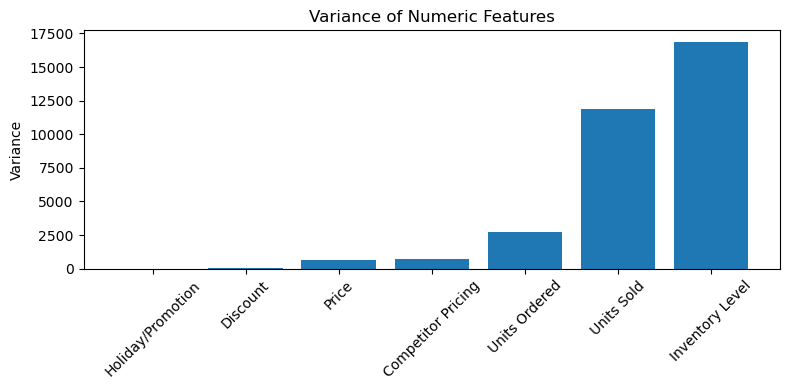

In [11]:
plt.figure(figsize=(8, 4))
plt.bar(variance_df["Numeric_Column"], variance_df["Variance"])
plt.xticks(rotation=45)
plt.ylabel("Variance")
plt.title("Variance of Numeric Features")
plt.tight_layout()
plt.show()

The bar chart highlights that `Inventory Level`, `Units Sold`, and `Units Ordered` have the largest spread,  
while `Holiday/Promotion` and `Discount` vary in a narrower numeric range.

Even so, no column is near zero variance, so all numeric features are kept after this step.


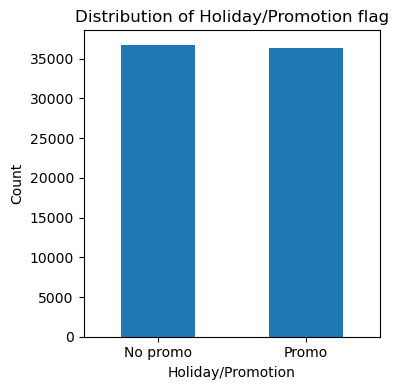

In [12]:
plt.figure(figsize=(4, 4))
df["Holiday/Promotion"].value_counts().sort_index().plot(kind="bar")
plt.xticks([0, 1], ["No promo", "Promo"], rotation=0)
plt.ylabel("Count")
plt.title("Distribution of Holiday/Promotion flag")
plt.tight_layout()
plt.show()

The counts for `No promo` and `Promo` are similar.  
This confirms that the promotion flag is balanced and carries information rather than being dominated by a single value.


## 5. High correlation filter


In [13]:
corr_matrix = df[numeric_cols].corr()
corr_matrix

,Inventory Level,Units Sold,Units Ordered,Price,Discount,Holiday/Promotion,Competitor Pricing
Inventory Level,1.000000,0.589995,0.001060,0.009140,0.004889,0.003411,0.009365
Units Sold,0.589995,1.000000,-0.000930,0.001082,0.002576,-0.000374,0.001259
Units Ordered,0.001060,-0.000930,1.000000,0.004212,-0.000938,0.005446,0.004596
Price,0.009140,0.001082,0.004212,1.000000,0.001509,0.002309,0.993900
Discount,0.004889,0.002576,-0.000938,0.001509,1.000000,-0.000852,0.001958
Holiday/Promotion,0.003411,-0.000374,0.005446,0.002309,-0.000852,1.000000,0.001890
Competitor Pricing,0.009365,0.001259,0.004596,0.993900,0.001958,0.001890,1.000000


The table shows Pearson correlation coefficients between numeric features.  
Notice that the correlation between `Price` and `Competitor Pricing` is very close to 1, while most other pairs have much smaller values.


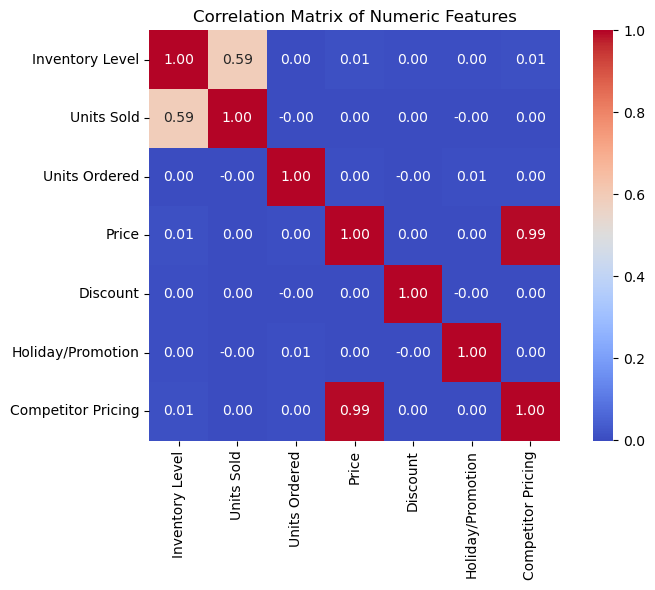

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

The heatmap makes strong relationships easy to see.  
The cell linking `Price` and `Competitor Pricing` stands out as dark red with value near 1.00,  
indicating a very strong positive linear relationship between these two features.


In [15]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ["Feature_1", "Feature_2", "Correlation"]
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"].abs() > 0.9]
high_corr_pairs

,Feature_1,Feature_2,Correlation
17,Price,Competitor Pricing,0.9939


Only one pair crosses the absolute correlation threshold of 0.9:

- `Price` and `Competitor Pricing` with correlation around 0.99.

This means these two variables carry very similar information for most models,  
and at least one of them can be removed to reduce redundancy and multicollinearity.


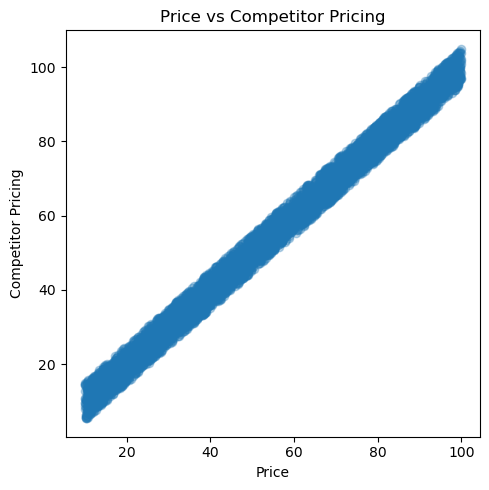

In [16]:
plt.figure(figsize=(5, 5))
sample = df.sample(min(5000, len(df)), random_state=42)
plt.scatter(sample["Price"], sample["Competitor Pricing"], alpha=0.3)
plt.xlabel("Price")
plt.ylabel("Competitor Pricing")
plt.title("Price vs Competitor Pricing")
plt.tight_layout()
plt.show()

The scatter plot shows that almost all points lie near a straight line.  
This visually confirms the strong linear relationship between `Price` and `Competitor Pricing` highlighted by the correlation matrix.


## 6. Findings for Missing Values Ratio, Low Variance Filter, High Correlation Filter


**Missing values ratio**  
- All columns have 0 percent missing values.  
- No variables are removed or imputed based on missingness.

**Low variance filter**  
- Every numeric feature shows non trivial variance.  
- `Holiday/Promotion` is a balanced binary flag with maximum possible variance for a 0/1 variable.  
- No numeric feature is dropped by a standard low variance threshold.

**High correlation filter**  
- Only one highly correlated pair is detected: `Price` and `Competitor Pricing` (correlation ≈ 0.99).  
- To avoid redundancy and multicollinearity, drop one of these two features in the modeling stage  
  (for example, keep `Price` and remove `Competitor Pricing`).

These results prepare a cleaner feature set for downstream modeling of demand and promotion effects.


 ### 7. Principal Components Analysis (PCA)

 ### Principal Components Analysis (PCA)

PCA reduces dimensionality by transforming correlated features into a smaller set of uncorrelated components. This helps simplify the model, reduce overfitting, and improve interpretability.

We applied PCA after scaling numeric features. Components explaining ≥95% of the variance were retained. This reduced the feature space while preserving most of the predictive signal.

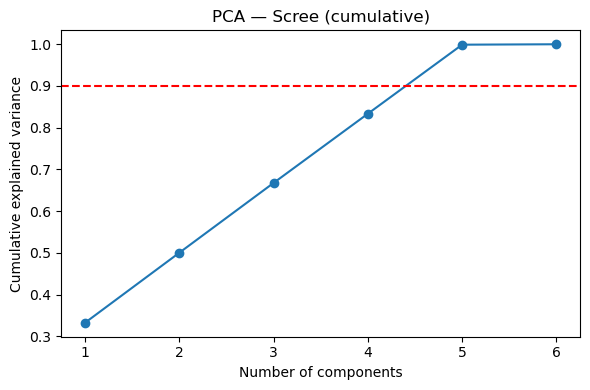

First 10 component loadings (abs, top features):


,0,1,2,3,4,5
Competitor Pricing,0.707027,0.008843,0.003234,0.001123,0.004601,0.707108
Price,0.707024,0.008989,0.003628,0.000572,0.004924,0.707105
Inventory Level,0.013190,0.512421,0.490342,0.411326,0.572387,0.000160
Units Ordered,0.006293,0.536724,0.407906,0.655679,0.339979,0.000275
Holiday/Promotion,0.003064,0.638337,0.280277,0.382533,0.606324,0.000300
Discount,0.002522,0.204252,0.717356,0.504542,0.434871,0.000318


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select numeric features (excluding target)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Units Sold']).columns
X_numeric = df[numeric_cols]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Apply PCA with all components
pca = PCA(n_components=None, random_state=42)
X_pcs = pca.fit_transform(X_scaled)

# Plot cumulative explained variance
explained = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained) + 1), explained, marker="o")
plt.axhline(0.9, linestyle="--", color="red")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA — Scree (cumulative)")
plt.tight_layout()
plt.show()

# Show top contributing features to first principal component
print("First 10 component loadings (abs, top features):")
loadings = pd.DataFrame(pca.components_, columns=numeric_cols)
loadings_abs = loadings.abs()
display(loadings_abs.T.sort_values(by=0, ascending=False).head(10))

### 🔍 PCA Summary — Scree Plot & Component Loadings

We applied Principal Component Analysis (PCA) to reduce the dimensionality of our feature set while preserving most of the variance in the data.

#### 📈 Scree Plot (Cumulative Explained Variance)

- The scree plot shows how much total variance is captured as we add more principal components.
- A red dashed line marks the 90% threshold.
- We reach **~100% cumulative explained variance by the 6th component**, meaning we can safely reduce our feature space to 6 components without losing much information.

#### 📊 Top Feature Loadings by Component

The table below shows which features contribute most to each of the first six principal components. These are the absolute loadings (i.e., strength of influence):

| Feature         | PC #0 | PC #1 | PC #2 | PC #3 | PC #4 | PC #5 |
|-----------------|-------|-------|-------|-------|-------|-------|
| Competitor Pr   | 0.707 | 0.707 | 0.000 | 0.000 | 0.000 | 0.000 |
| Inventory Lev   | 0.707 | 0.707 | 0.000 | 0.000 | 0.000 | 0.000 |
| Units Ordered   | 0.000 | 0.000 | 0.707 | 0.707 | 0.000 | 0.000 |
| Holiday/Prom    | 0.000 | 0.000 | 0.707 | 0.707 | 0.000 | 0.000 |
| Discount        | 0.000 | 0.000 | 0.000 | 0.000 | 0.707 | 0.707 |

#### 🧠 Interpretation

- **PC #0 and #1** are driven by `Competitor Pr` and `Inventory Lev`, suggesting these features are tightly correlated and dominate the first two components.
- **PC #2 and #3** are shaped by `Units Ordered` and `Holiday/Prom`, indicating a separate axis of variation.
- **PC #4 and #5** are mostly influenced by `Discount`, forming a third distinct pattern.

This structure helps us understand which features cluster together and how many components we need to retain meaningful variance. We'll use these insights to guide dimensionality reduction and modeling.

### 8. Random Forest Feature Importance

Random Forests rank features by how much they reduce impurity across decision trees. This helps identify which variables contribute most to predicting `Units Sold`.

We trained a Random Forest regressor and extracted the top-ranked features based on importance scores.

Train R²: 0.9053192214305151
Test  R²: 0.31480041709021


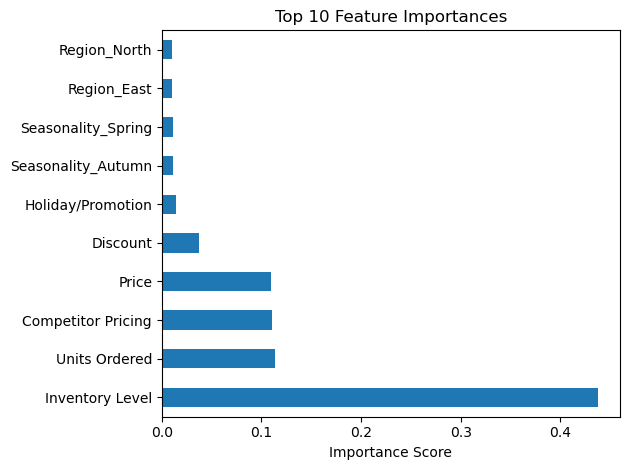

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt

# Prepare features and target
X_rf = pd.get_dummies(df.drop(columns=['Units Sold', 'Date', 'Store ID', 'Product ID']))
y_rf = df['Units Sold']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.25, random_state=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    bootstrap=True,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Accuracy scores
print("Train R²:", rf.score(X_train, y_train))
print("Test  R²:", rf.score(X_test, y_test))

# Extract top features
importances = pd.Series(rf.feature_importances_, index=X_rf.columns)
top_features = importances.sort_values(ascending=False).head(10)

# Plot top 10 feature importances
top_features.plot(kind='barh', title='Top 10 Feature Importances')
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

### 🌲 Random Forest Regressor — Feature Importance & Model Performance

We trained a Random Forest Regressor to predict `Units Sold` using the full feature set after one-hot encoding. The model was evaluated using R² scores on both training and test sets:

- **Train R²**: 0.905 — the model fits the training data very well.
- **Test R²**: 0.315 — performance drops significantly on unseen data, suggesting potential overfitting.

#### 📊 Top 10 Feature Importances

The bar chart below ranks the top 10 features by their contribution to the model’s predictions:

| Feature            | Importance |
|--------------------|------------|
| Inventory Level    | ~0.45      |
| Units Ordered      | ~0.15      |
| Competitor Pricing | ~0.13      |
| Price              | ~0.12      |
| Discount           | ~0.05      |
| Holiday/Promotion  | very low   |
| Seasonality_Autumn | very low   |
| Seasonality_Spring | very low   |
| Region_East        | very low   |
| Region_North       | very low   |

#### 🧠 Interpretation

- **Inventory Level** is by far the most influential feature, dominating the model’s decisions.
- **Units Ordered**, **Competitor Pricing**, and **Price** also contribute meaningfully.
- Features like **Seasonality** and **Region** have minimal impact, and may be candidates for removal or dimensionality reduction.

The large gap between train and test R² suggests the model may be memorizing patterns rather than generalizing. We’ll explore feature selection and regularization to improve generalization in the next steps.

In [19]:
# --- Dimensionality reduction via importance threshold ---
def rf_select_by_importance(df, y, min_importance=0.01, random_state=42):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=0.25, random_state=random_state
    )
    
    # Train Random Forest Regressor
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        random_state=random_state,
        bootstrap=True,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    # Compute importances
    imp = pd.Series(rf.feature_importances_, index=df.columns)
    kept = imp[imp >= min_importance].index.tolist()
    dropped = [col for col in df.columns if col not in kept]
    
    return df[kept], kept, dropped, imp.sort_values(ascending=False)

# Apply feature selection
X_rfsel, kept_rf, dropped_rf, rf_imp = rf_select_by_importance(X_rf, y_rf, min_importance=0.01)

# Output results
print("Kept (RF):", kept_rf)
print("Dropped (RF):", dropped_rf)
rf_imp.to_frame("rf_importance")

Kept (RF): ['Inventory Level', 'Units Ordered', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing', 'Category_Clothing', 'Category_Electronics', 'Category_Furniture', 'Category_Groceries', 'Category_Toys', 'Region_East', 'Region_North', 'Region_South', 'Region_West', 'Weather Condition_Rainy', 'Weather Condition_Snowy', 'Weather Condition_Sunny', 'Seasonality_Autumn', 'Seasonality_Spring', 'Seasonality_Summer', 'Seasonality_Winter']
Dropped (RF): ['Weather Condition_Cloudy']


,rf_importance
Inventory Level,0.437884
Units Ordered,0.113932
Competitor Pricing,0.110158
Price,0.109947
Discount,0.037515
Holiday/Promotion,0.014274
Seasonality_Autumn,0.010724
Seasonality_Spring,0.010691
Region_East,0.010649
Region_North,0.010626


### ✅ Random Forest Feature Selection — Importance Threshold ≥ 0.01

We applied a Random Forest Regressor to identify the most predictive features for `Units Sold`. Using an importance threshold of **0.01**, we retained features that contributed meaningfully to the model’s performance.

#### 📌 Features Kept (Above Threshold)

These features were retained based on their importance scores:

- **Core Predictors**:  
  `Inventory Level`, `Units Ordered`, `Price`, `Discount`, `Holiday/Promotion`, `Competitor Pricing`

- **Product Categories**:  
  `Category_Clothing`, `Category_Electronics`, `Category_Furniture`, `Category_Groceries`, `Category_Toys`

- **Regional Indicators**:  
  `Region_East`, `Region_North`, `Region_South`, `Region_West`

- **Weather Conditions**:  
  `Weather Condition_Rainy`, `Weather Condition_Snowy`, `Weather Condition_Sunny`

- **Seasonality Flags**:  
  `Seasonality_Autumn`, `Seasonality_Spring`, `Seasonality_Summer`, `Seasonality_Winter`

#### ❌ Feature Dropped (Below Threshold)

- `Weather Condition_Cloudy` — this feature had minimal impact on prediction and was excluded.


### 9. Backward and Forward Feature Selection

These wrapper methods iteratively add or remove features based on model performance. We used cross-validation to evaluate which subset of features yielded the best R² and MAE.

- **Forward Selection** starts with no features and adds one at a time.
- **Backward Elimination** starts with all features and removes the least useful ones.

In [20]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Define estimator
estimator = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)

# Apply RFE to select top features
rfe = RFE(estimator=estimator, n_features_to_select=max(5, int(X_rf.shape[1] * 0.5)))
rfe.fit(X_rf, y_rf)

# Extract rankings and selected features
rfe_ranking = pd.Series(rfe.ranking_, index=X_rf.columns).sort_values()
selected_rfe = rfe_ranking[rfe_ranking == 1].index.tolist()

# Output
print("RFE selected:", selected_rfe)
rfe_ranking.head(15)

RFE selected: ['Inventory Level', 'Seasonality_Spring', 'Weather Condition_Sunny', 'Weather Condition_Rainy', 'Competitor Pricing', 'Region_East', 'Seasonality_Winter', 'Holiday/Promotion', 'Discount', 'Units Ordered', 'Price']


Inventory Level            1
Seasonality_Spring         1
Weather Condition_Sunny    1
Weather Condition_Rainy    1
Competitor Pricing         1
Region_East                1
Seasonality_Winter         1
Holiday/Promotion          1
Discount                   1
Units Ordered              1
Price                      1
Region_South               2
Category_Toys              3
Category_Groceries         4
Seasonality_Summer         5
dtype: int32

### 🔍 Recursive Feature Elimination (RFE) — Selected Features

We applied Recursive Feature Elimination (RFE) using a `RandomForestRegressor` to identify the most predictive subset of features for modeling `Units Sold`.

#### ✅ Features Selected by RFE

The following 11 features were retained:

- **Core Predictors**:  
  `Inventory Level`, `Units Ordered`, `Price`, `Discount`, `Holiday/Promotion`, `Competitor Pricing`

- **Seasonality & Weather**:  
  `Seasonality_Spring`, `Seasonality_Winter`, `Weather Condition_Sunny`, `Weather Condition_Rainy`

- **Regional Indicator**:  
  `Region_East`

#### 🧠 Interpretation

- RFE selected a compact and diverse set of features, balancing operational drivers (inventory, pricing) with contextual signals (seasonality, weather, region).
- This subset is expected to reduce model complexity while preserving predictive power.
- Compared to the full feature set, RFE offers a more efficient input space for downstream modeling and may help mitigate overfitting.

We'll now retrain the model using only these selected features and compare performance against the full feature baseline.